<a href="https://colab.research.google.com/github/owaikien/LSTM-bitcoin-prediction/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
np.random.seed(42)
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from datetime import date, timedelta, datetime
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from keras.layers import CuDNNLSTM
from keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8


In [3]:
!pip install cryptocompare

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for cryptocompare: filename=cryptocompare-0.7.6-py3-none-any.whl size=6302 sha256=34aa6b6da5038a8c2c08a7fce843af273dc11e0869cee4f7848303c092084fb2
  Stored in directory: /root/.cache/pip/wheels/7c/68/85/ea0b03b801d06a49d1eef47cbdc24a413a2c2a4a011299ebf7
Successfully built cryptocompare


# Importing Data

#### Price Data

In [5]:
sns.set_style('white', {'axes.spines.right':True, 'axes.spines.top':False})
import cryptocompare as cc
import requests
import IPython
import yaml
import json

# Remember to import your API key into current Google Colab directory
# Set the API key from yaml file
yaml_file = open("sample_data/chain_api.yml")
p = yaml.load(yaml_file, Loader=yaml.FullLoader)
api_key = p['api_key']

# Number of days we retrieve data
data_limit = 2000

# Define pairs
fysm = 'BTC'
tysm = 'USD' 

# Query data
def api_call(url):
    # Set API key as Header
    headers = {'authorization':'Apikey' + api_key,}
    session = requests.Session()
    session.headers.update(headers)

    # API call to cryptocompare
    response = session.get(url)

    # Conversion of the response to dataframe
    historic_blockdata_dict = json.loads(response.text)
    df = pd.DataFrame.from_dict(historic_blockdata_dict['Data']['Data'], orient='columns', dtype=None, columns=None)

    return df

def call_all():
    dfs = []
    # 1st call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}')
    dfs.append(df)
    # defining the latest time point for the next call
    latest = df['time'][0]

    # 2nd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    dfs.append(df)
    latest = df['time'][0]

    # 3rd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    dfs.append(df)

    dfs = pd.concat(dfs, ignore_index=True)
    dfs['date'] = pd.to_datetime(dfs['time'], unit='s')

    return dfs

# sort df by date, drop values with 0 and unnecessary columns, drop duplicates row and reset index 
base_url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym='
btcprice = call_all()
btcprice.sort_values(by='date', inplace=True)
btcprice = btcprice.loc[~(btcprice['close']==0)]
btcprice.drop(columns=['time', 'conversionType', 'conversionSymbol', 'high', 'low', 'open', 'volumefrom', 'volumeto'], inplace=True)
btcprice = btcprice.drop_duplicates(subset='date', keep='first')
btcprice = btcprice.reset_index(drop=True)
btcprice


,close,date
0,0.04951,2010-07-17
1,0.08584,2010-07-18
2,0.08080,2010-07-19
3,0.07474,2010-07-20
4,0.07921,2010-07-21
...,...,...
4606,23167.45000,2023-02-25
4607,23557.39000,2023-02-26
4608,23490.07000,2023-02-27
4609,23134.20000,2023-02-28


### Volume Data

In [ ]:
# Volume dataframe
# Query data
def api_call(url):
    # Set API key as Header
    headers = {'authorization':'Apikey' + api_key,}
    session = requests.Session()
    session.headers.update(headers)

    # API call to cryptocompare
    response = session.get(url)

    # Conversion of the response to dataframe
    historic_blockdata_dict = json.loads(response.text)
    df = pd.DataFrame.from_dict(historic_blockdata_dict['Data'], orient='columns', dtype=None, columns=None)

    return df

def call_all():
    dfs = []
    # 1st call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}')
    dfs.append(df)
    # defining the latest time point for the next call
    latest = df['time'][0]

    # 2nd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    dfs.append(df)
    latest = df['time'][0]

    # 3rd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    dfs.append(df)

    dfs = pd.concat(dfs, ignore_index=True)
    dfs['date'] = pd.to_datetime(dfs['time'], unit='s')

    return dfs

base_url = 'https://min-api.cryptocompare.com/data/exchange/histoday?fsym='
volume = call_all()
volume.sort_values(by='date', inplace=True)
volume = volume.loc[~(volume['volume']==0)]
volume.drop(columns=['time'], inplace=True)
volume = volume.drop_duplicates(subset='date', keep='first')
volume = volume.reset_index(drop=True)
volume



,volume,date
0,1.471840e+03,2013-03-11
1,1.796934e+04,2013-03-12
2,1.148273e+04,2013-03-13
3,1.269439e+04,2013-03-14
4,2.271394e+04,2013-03-15
...,...,...
3638,1.900420e+10,2023-02-25
3639,1.801049e+10,2023-02-26
3640,2.440426e+10,2023-02-27
3641,2.087257e+10,2023-02-28


### Onchain Data

In [ ]:
# Generic function for an API call to a given URL
def api_call(url):
  # Set API Key as Header
  headers = {'authorization': 'Apikey ' + api_key,}
  session = requests.Session()
  session.headers.update(headers)

  # API call to cryptocompare
  response = session.get(url)

  # Conversion of the response to dataframe
  historic_blockdata_dict = json.loads(response.text)
  df = pd.DataFrame.from_dict(historic_blockdata_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)
  return df

# Prepare the onchain dataframe
def call_all():
    dfs = []
    # 1st call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}')
    df = df[df['hashrate'] > 0.0]
    dfs.append(df)
    latest = df['time'][0]

    # 2nd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    df = df[df['hashrate'] > 0.0]
    dfs.append(df)
    latest = df['time'][0]

    # 3rd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    df = df[df['hashrate'] > 0.0]
    dfs.append(df)

    dfs = pd.concat(dfs, ignore_index=True)
    dfs['date'] = pd.to_datetime(dfs['time'], unit='s')

    return dfs

# Load onchain data for Bitcoin
base_url = 'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym='
onchain = call_all()
# sort df by date from oldest to newest
onchain.sort_values(by='date', inplace=True, ascending=True)
onchain.drop(columns=['unique_addresses_all_time','id', 'symbol', 'time', 'block_height', 
                      'average_transaction_value', 'block_time', 'block_size', 'current_supply', 'transaction_count'], inplace=True)
onchain = onchain.drop_duplicates(subset='date', keep='first')
onchain = onchain.reset_index(drop=True)
# latest day on chain data is unavailable
onchain

,zero_balance_addresses_all_time,new_addresses,active_addresses,transaction_count_all_time,large_transaction_count,hashrate,difficulty,date
0,0,14,14,15,0,9.425148e-06,1.000000e+00,2009-01-09
1,0,61,61,76,0,3.730645e-06,1.000000e+00,2009-01-10
2,0,93,93,169,0,4.669160e-06,1.000000e+00,2009-01-11
3,2,101,102,270,0,5.440074e-06,1.000000e+00,2009-01-12
4,2,123,123,393,0,6.124981e-06,1.000000e+00,2009-01-13
...,...,...,...,...,...,...,...,...
5155,1070951981,455833,964183,808465445,13985,2.624773e+08,3.915640e+13,2023-02-24
5156,1071271254,420596,817375,808723858,10308,2.290169e+08,4.283530e+13,2023-02-25
5157,1071725332,436293,918618,809000961,10163,3.611618e+08,4.305384e+13,2023-02-26
5158,1072175979,422468,971028,809293709,13154,3.004005e+08,4.305384e+13,2023-02-27


### Coin Distribution Data

In [ ]:
# retrieving number of bitcoin distributed among the stakeholders
# separate API (data/blockchain/balancedistribution/histo)
# Prepare balance distribution dataframe
def prepare_balancedistribution_data(df):
  df['balance_distribution'] = df['balance_distribution'].apply(lambda x: [i for i in x])
  json_struct = json.loads(df[['time','balance_distribution']].to_json(orient="records"))    
  df_ = pd.json_normalize(json_struct)
  df_['date'] = pd.to_datetime(df_['time'], unit='s')
  df_flat = pd.concat([df_.explode('balance_distribution').drop(['balance_distribution'], axis=1),
           df_.explode('balance_distribution')['balance_distribution'].apply(pd.Series)], axis=1)
  df_flat.reset_index(drop=True, inplace=True)
  df_flat['range'] = ['' + str(float(df_flat['from'][x])) + '_to_' + str(float(df_flat['to'][x])) for x in range(df_flat.shape[0])]
  df_flat.drop(columns=['from','to'], inplace=True)

  # Data cleansing
  df_flat = df_flat[~df_flat['range'].isin(['100000.0_to_0.0'])]
  df_flat['range'].iloc[df_flat['range'] == '1e-08_to_0.001'] = '0.0_to_0.001'
  return df_flat

def call_all():
    dfs = []
    # 1st call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}')
    df = prepare_balancedistribution_data(df)
    dfs.append(df)
    latest = df['time'][0]

    # 2nd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    df = prepare_balancedistribution_data(df)
    dfs.append(df)
    latest = df['time'][0]

    # 3rd call
    df = api_call(f'{base_url}BTC&tsym=USD&limit={data_limit}&toTs={latest}')
    df = prepare_balancedistribution_data(df)
    dfs.append(df)

    dfs = pd.concat(dfs, ignore_index=True)
    #dfs['date'] = pd.to_datetime(dfs['time'], unit='s')

    return dfs

# Load the balance distribution data for Bitcoin
base_url = 'https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym='
distribution = call_all()
distribution.drop(columns=['time'], inplace=True)
distribution = distribution.sort_values(by='date', ascending=True)
distribution.reset_index(drop=True, inplace=True)
distribution

,date,totalVolume,addressesCount,range
0,2009-01-03,0.000000e+00,0.0,0.0_to_0.001
1,2009-01-03,0.000000e+00,0.0,100000.0_to_1000000.0
2,2009-01-03,0.000000e+00,0.0,10000.0_to_100000.0
3,2009-01-03,0.000000e+00,0.0,1000.0_to_10000.0
4,2009-01-03,0.000000e+00,0.0,100.0_to_1000.0
...,...,...,...,...
47094,2023-02-27,4.591438e+06,1918.0,1000.0_to_10000.0
47095,2023-02-27,2.338929e+06,110.0,10000.0_to_100000.0
47096,2023-02-27,4.539665e+03,22510830.0,0.0_to_0.001
47097,2023-02-27,3.850296e+04,10269160.0,0.001_to_0.01


In [ ]:
df_distr = distribution.copy()
df_distr.reset_index(drop=True, inplace=True)
df_distr = df_distr.pivot_table(values='addressesCount', index='date', columns='range')
df_distr.fillna(method='ffill', inplace=True)
distr = df_distr[['1000.0_to_10000.0', '10000.0_to_100000.0']]
distr

range,1000.0_to_10000.0,10000.0_to_100000.0
date,,
2009-01-03,0.0,0.0
2009-01-04,0.0,0.0
2009-01-05,0.0,0.0
2009-01-06,0.0,0.0
2009-01-07,0.0,0.0
...,...,...
2023-02-23,1915.0,111.0
2023-02-24,1917.0,109.0
2023-02-25,1916.0,109.0


### Merge all data

In [ ]:
final = btcprice.merge(onchain, on='date', how='left').merge(distr, on='date', how='left').merge(volume, on='date', how='left')
final['yesterday'] = final['close'].shift(1)
final.fillna(method='ffill', inplace=True)
final.fillna(method='backfill', inplace=True)
final.head()

,close,date,zero_balance_addresses_all_time,new_addresses,active_addresses,transaction_count_all_time,large_transaction_count,hashrate,difficulty,1000.0_to_10000.0,10000.0_to_100000.0,volume,yesterday
0,0.04951,2010-07-17,34727.0,447.0,804.0,87062.0,0.0,0.001588,181.543289,9.0,0.0,1471.84,0.04951
1,0.08584,2010-07-18,35257.0,467.0,917.0,87482.0,0.0,0.001625,181.543289,21.0,2.0,1471.84,0.04951
2,0.08080,2010-07-19,35744.0,605.0,972.0,88010.0,0.0,0.001578,181.543289,29.0,4.0,1471.84,0.08584
3,0.07474,2010-07-20,36257.0,674.0,906.0,88604.0,0.0,0.001634,181.543289,32.0,5.0,1471.84,0.08080
4,0.07921,2010-07-21,36679.0,469.0,809.0,89067.0,0.0,0.001866,181.543289,33.0,7.0,1471.84,0.07474


### Pearson Correlation

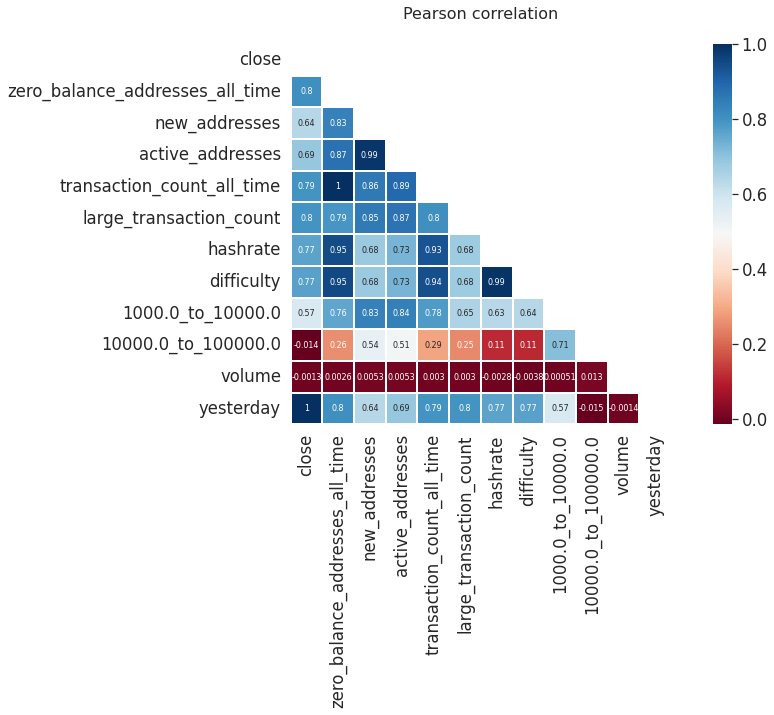

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15,7))
plt.title("Pearson correlation", y=1.05, size=16)

mask = np.zeros_like(final.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(final.corr(), mask=mask, linewidths=1.5, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"fontsize":8})
plt.show()

In [ ]:
final.columns

Index(['close', 'date', 'zero_balance_addresses_all_time', 'new_addresses',
       'active_addresses', 'transaction_count_all_time',
       'large_transaction_count', 'hashrate', 'difficulty',
       '1000.0_to_10000.0', '10000.0_to_100000.0', 'volume', 'yesterday'],
      dtype='object')

### Prepare final data

In [ ]:
df = final.loc[:, ['date', 'yesterday', 'zero_balance_addresses_all_time', 'large_transaction_count', 
                         'transaction_count_all_time', 'hashrate', 'close']]
df.head()


,date,yesterday,zero_balance_addresses_all_time,large_transaction_count,transaction_count_all_time,hashrate,close
0,2010-07-17,0.04951,34727.0,0.0,87062.0,0.001588,0.04951
1,2010-07-18,0.04951,35257.0,0.0,87482.0,0.001625,0.08584
2,2010-07-19,0.08584,35744.0,0.0,88010.0,0.001578,0.08080
3,2010-07-20,0.08080,36257.0,0.0,88604.0,0.001634,0.07474
4,2010-07-21,0.07474,36679.0,0.0,89067.0,0.001866,0.07921


In [ ]:
df.columns = df.columns.str.title()
df.head()

,Date,Yesterday,Zero_Balance_Addresses_All_Time,Large_Transaction_Count,Transaction_Count_All_Time,Hashrate,Close
0,2010-07-17,0.04951,34727.0,0.0,87062.0,0.001588,0.04951
1,2010-07-18,0.04951,35257.0,0.0,87482.0,0.001625,0.08584
2,2010-07-19,0.08584,35744.0,0.0,88010.0,0.001578,0.08080
3,2010-07-20,0.08080,36257.0,0.0,88604.0,0.001634,0.07474
4,2010-07-21,0.07474,36679.0,0.0,89067.0,0.001866,0.07921


Text(0, 0.5, 'Close Price (USD)')

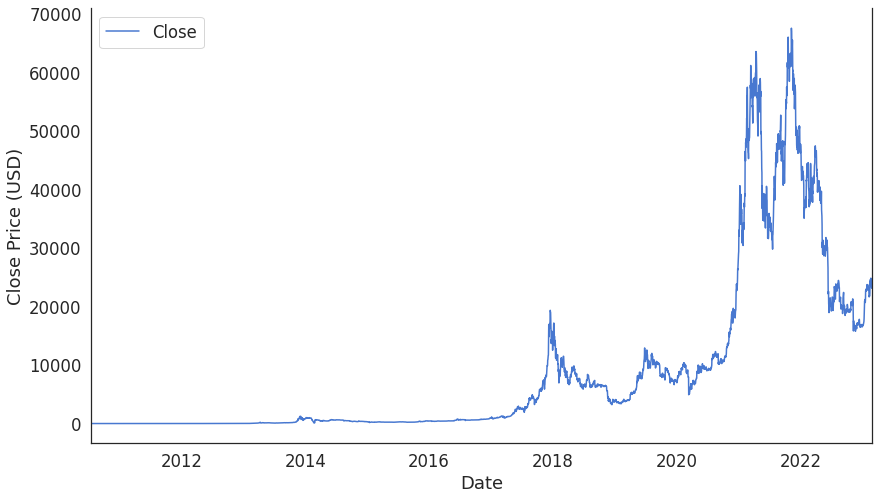

In [ ]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

### Split and scale data

In [ ]:
scaler = MinMaxScaler()

# skipping first column (data)
train_features = df.iloc[:int(len(df)*0.85), 1:].values.reshape(-1, 6)
test_features = df.iloc[int(len(df)*0.85):, 1:].values.reshape(-1, 6)

scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

In [ ]:
scaled_train_features.shape

(3919, 6)

In [ ]:
scaled_test_features.shape

(692, 6)

In [ ]:
np.isnan(scaled_train_features).any()

False

In [ ]:
np.isnan(scaled_test_features).any()

False

### Prepare sequential data

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(train_features, test_features, seq_len):

    train = to_sequences(train_features, seq_len)
    # X_trainc and X_test is a tensor 
    # with shape (n_sequences, seq_len-1, num_features)
    # y_train is a tensor 
    # with shape (num_sequences, 1)
    X_train = train[:, :-1, :]
    y_train = train[:, -1, -1].reshape(-1, 1)

    test = to_sequences(test_features, seq_len)
    X_test = test[:, :-1, :]
    y_test = test[:, -1, -1].reshape(-1, 1)

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_train_features, scaled_test_features, SEQ_LEN)

In [ ]:
print(X_train.shape, y_train.shape)

(3819, 99, 6) (3819, 1)


In [ ]:
print(X_test.shape, y_test.shape)

(592, 99, 6) (592, 1)


### Build model

In [ ]:
# model building
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

### Train model

In [ ]:
# compile
model.compile(
    loss='mean_squared_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

In [ ]:
# model fitting
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
54/54 [==============================] - 10s 57ms/step - loss: 8.2204e-04 - val_loss: 0.0846
Epoch 2/50
54/54 [==============================] - 2s 38ms/step - loss: 0.0011 - val_loss: 0.1165
Epoch 3/50
54/54 [==============================] - 2s 38ms/step - loss: 0.0013 - val_loss: 0.0498
Epoch 4/50
54/54 [==============================] - 2s 38ms/step - loss: 0.0017 - val_loss: 0.0272
Epoch 5/50
54/54 [==============================] - 2s 40ms/step - loss: 9.4910e-04 - val_loss: 0.0636
Epoch 6/50
54/54 [==============================] - 2s 39ms/step - loss: 0.0010 - val_loss: 0.0646
Epoch 7/50
54/54 [==============================] - 2s 38ms/step - loss: 3.0674e-04 - val_loss: 0.0408
Epoch 8/50
54/54 [==============================] - 2s 38ms/step - loss: 5.6589e-04 - val_loss: 0.0466
Epoch 9/50
54/54 [==============================] - 2s 38ms/step - loss: 4.0449e-04 - val_loss: 0.0429
Epoch 10/50
54/54 [==============================] - 2s 39ms/step - loss: 6.2126e-04 - v

In [ ]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 1s 41ms/step - loss: 0.0540


0.054006148129701614

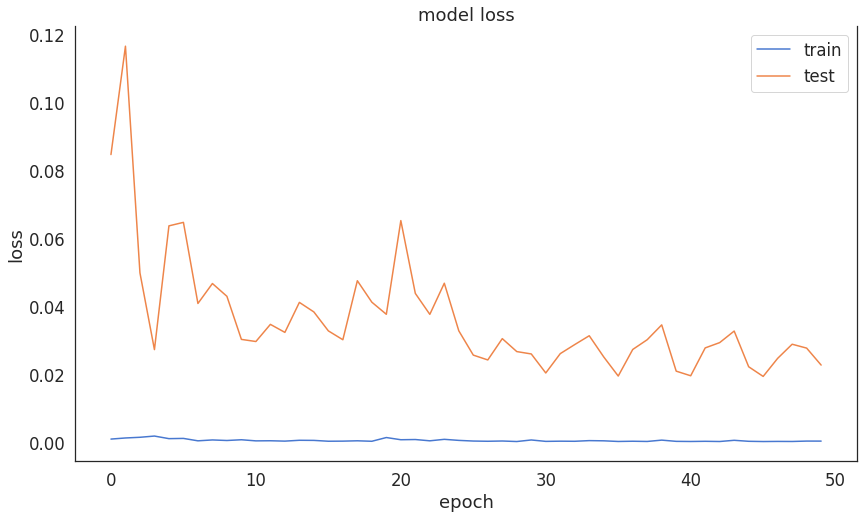

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Predict

In [ ]:
y_hat = model.predict(X_test)

y_test_reshaped = np.zeros_like(scaled_test_features[:, -1:])
y_test_reshaped[-y_test.shape[0]:, :] = y_test.reshape(-1, 1)

y_hat_reshaped = np.zeros_like(scaled_test_features[:, -1:])
y_hat_reshaped[-y_hat.shape[0]:, :] = y_hat.reshape(-1, 1)

# inverse transform y_test and y_hat
y_test_inverse = scaler.inverse_transform(np.concatenate((scaled_test_features[:, :-1], y_test_reshaped), axis=1))[:, -1]
y_hat_inverse = scaler.inverse_transform(np.concatenate((scaled_test_features[:, :-1], y_hat_reshaped), axis=1))[:, -1]

19/19 [==============================] - 1s 19ms/step


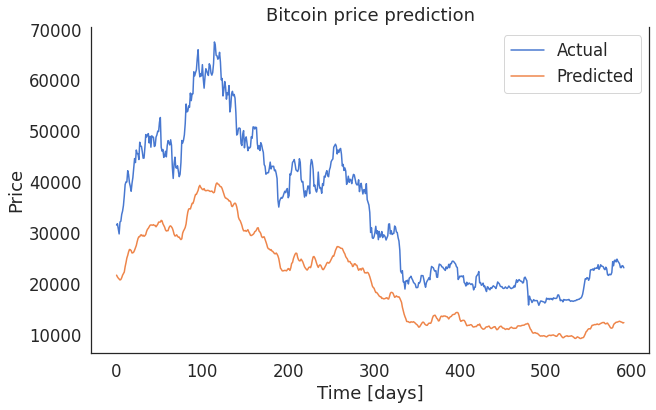

In [ ]:
# visualize
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse[(len(y_test_inverse)-y_test.shape[0]):], label='Actual')
plt.plot(y_hat_inverse[(len(y_hat_inverse)-y_test.shape[0]):], label='Predicted')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show()

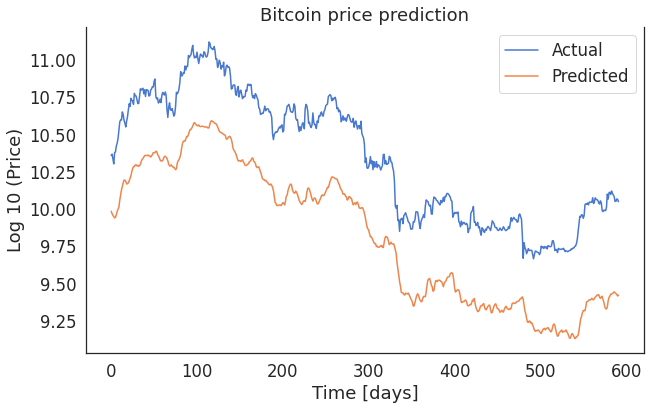

In [ ]:
# log version
plt.figure(figsize=(10, 6))
plt.plot(np.log(y_test_inverse[(len(y_test_inverse)-y_test.shape[0]):]), label='Actual')
plt.plot(np.log(y_hat_inverse[(len(y_hat_inverse)-y_test.shape[0]):]), label='Predicted')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Log 10 (Price)')
plt.legend(loc='best')

plt.show()